$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\mP}{{\bf P}}
\newcommand{\mU}{{\bf U}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\vb}{{\bf b}}
\newcommand{\vz}{{\bf z}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\mb}{{\bf B}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [43]:
include("fanote_init.jl")

# Chapter 2: Finding the Newton Step with Gaussian Elimination

## Contents for Chapter 2

[Section 2.1: Direct Methods for Solving Linear Equations](#Section-2.1:-Direct-Methods-for-Solving-Linear-Equations)

[Section 2.2: The Newton-Armijo Iteration](#Section-2.2:-The-Newton-Armijo-Iteration)

[Section 2.3: Computing a Finite Difference Jacobian](#Section-2.3:-Computing-a-Finite-Difference-Jacobian)

[Section 2.4: The Chord and Shamanskii Methods](#Section-2.4:-The-Chord-and-Shamanskii-Methods)

[Section 2.5: What Can Go Wrong?](#Section-2.5:-What-Can-Go-Wrong?)

[Section 2.6: Four Nonlinear Systems](#Section-2.6:-Four-Nonlinear-Systems)



Direct methods for solving the equation for the Newton step
are a good idea if

- the Jacobian can be computed and __stored__ efficiently and
- the cost of the factorization of the Jacobian is not excessive or
- iterative methods do not converge for your problem.


Even when direct methods work well,
Jacobian factorization and storage of that
factorization may be more expensive than a solution by iteration.
However, direct methods are more robust than iterative methods and
do not require your worrying about
the possible convergence failure of an iterative method or
preconditioning.

If the linear equation for the Newton step is solved exactly
and the Jacobian is computed and factored with each nonlinear
iteration (i.e., $\eta = 0$ in Algorithm __nsolg__), one should
expect to see q-quadratic convergence until finite-precision
effects produce stagnation (as predicted in __Theorem 1.2__.
One can, of course, approximate the Jacobian or evaluate it only
a few times during the nonlinear iteration, exchanging an increase
in the number of nonlinear iterations for a dramatic reduction in
the cost of the computation of the steps.

In many cases, as we pointed out in __Chapter 1__,
one can store and factor $\mf'$ in reduced precision
with no loss in the quality of the solution. If, as we
do in this book, one computes $\mf$ in double precision (Float64), storing
and factoring $\mf'$ in single precision (Float32) cuts the linear algebra
cost in half. Our solvers enable you to do this with ease by allocating
the storage for $\mf'$ in single precision. We have a detailed example
of this in the notebook.

The Julia codes for the examples in this chapter are in the
[src/Chapter2](src/Chapter2) directory for the notebook. 



## Section 2.1: Direct Methods for Solving Linear Equations

In this chapter we solve the equation for the Newton step with
Gaussian elimination. As is standard in numerical linear algebra
(see \cite{golub,trefbau,demmel,stewart}, for example),
we distinguish between the factorization and the solve.
The typical implementation of Gaussian elimination, called
an __LU factorization__,
factors the coefficient matrix
$\ma$ into a product of a permutation matrix and
lower and upper triangular factors:
$$
\ma = \mP \ml \mU.
$$
The factorization may be simpler and less costly if the matrix
has an advantageous structure (sparsity, symmetry, positivity, ...)
<cite data-cite="golub"><a href="siamfa.html#golub">(GV96)</cite>,
<cite data-cite="stewart"><a href="siamfa.html#stewart">(Ste73)</cite>,
<cite data-cite="trefbau"><a href="siamfa.html#trefbau">(TB96)</cite>,
<cite data-cite="demmel"><a href="siamfa.html#demmel">(Dem97)</cite>,
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>,
<cite data-cite="lapack"><a href="siamfa.html#lapack">(ABB<sup>+</sup>92)</cite>.

The permutation matrix reflects row interchanges that are done during
the factorization to improve stability. In Julia the best way to
do this is to factor $\ma$ __in-place__. This means that $\ml$
and $\mU$ are stored by __overwriting__ $\ma$ and the permutation is
recorded in an integer vector. Julia's convention for a function that
overwrites it's input is to put a $!$ after the name of the function.
So you invoke the LU factorization with

```Julia
B = lu!(A).
```

There is a subtle point here that really matters for Newton's method.
While $\mb$ and $\ma$ share storage, they are different data structures.
One can, for example, update $\ma$ as a matrix, as one would do in a
nonlinear solver if $\ma$ is an approximation of the Jacobian. One cannot
do that if one makes the call as

```Julia
A = lu!(A),
```
because then you have changed the data type of $\ma$.

For example, let
$$
\ma = \left(
\begin{array}{ccc}
4 & 6 & 6 \\ 2 & 2 & 3 \\ 7 & 8 & 10
\end{array}
\right)\!.
$$
The LU factorization
```Julia
[l,u]=lu(A)
```
returned by the Julia command is
```Julia
julia> B=lu!(A)
LU{Float64,Array{Float64,2}}
L factor:
3×3 Array{Float64,2}:
 1.00000e+00   0.00000e+00  0.00000e+00
 5.71429e-01   1.00000e+00  0.00000e+00
 2.85714e-01  -2.00000e-01  1.00000e+00
U factor:
3×3 Array{Float64,2}:
 7.00000e+00  8.00000e+00  1.00000e+01
 0.00000e+00  1.42857e+00  2.85714e-01
 0.00000e+00  0.00000e+00  2.00000e-01
```

The permutation is elsewhere in $B$. To see this
```Julia
julia> B.L * B.U
3×3 Array{Float64,2}:
 7.00000e+00  8.00000e+00  1.00000e+01
 4.00000e+00  6.00000e+00  6.00000e+00
 2.00000e+00  2.00000e+00  3.00000e+00
```
Indicating that $\ml \mU = \mP^T \ma$. The permutation vector is
```Julia
julia> B.p
3-element Array{Int64,1}:
 3
 1
 2
```

We use the output of ```lu!``` with the standard backslash notation. So
to solve $\ma \vx = \vb$ one would do this.
```
julia> B=lu!(A);
julia> s=B\b;
```
In the REPL, the semicolon suppresses output, just as it does in Matlab.

We will ignore the permutation for the remainder of this chapter, but
the reader should remember that it is important. Most
linear algebra software
<cite data-cite="lapack"><a href="siamfa.html#lapack">(ABB<sup>+</sup>92)</cite>,
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>
manages the permutation for you in some way.
    
The cost of an LU factorization of an $N \times N$ matrix
is $N^3/3 + O(N^2)$ flops, where, following
<cite data-cite="linpack"><a href="siamfa.html#linpack">(DMBS79)</cite>,
we define a flop as an add, a multiply, and some address computations.
The factorization is the most expensive part of the solution.

Following the factorization, one can solve the linear system as we
described above. Internally that means to solve
$\ma \vs = \vb$ by solving the two triangular systems $\ml \vz = \vb$ and
$\mU \vs = \vz$. The cost of the two triangular solves is $N^2 + O(N)$
flops.

One final point, which we will return to soon, is that using ```lu!```
rather than ```lu``` is very important. The ```lu``` function performs
the same factorization, but allocates new storage for the results rather
than overwriting the original matrix. The penalty for allocating memory
in Julia is severe and one must take care to avoid it.


## Section 2.2: The Newton-Armijo Iteration

Algorithm __newton__ is an implementation of Newton's method that
uses Gaussian elimination to compute the Newton
step. The significant contributors to the computational cost
are the computation and LU factorization of the Jacobian.
The factorization can fail if, for example,
$\mf'$ is singular or highly ill-conditioned.

![Alg2.1](Images/Alg2dot1.png)

The Newton-like solvers in this chapter all follow this paradigm. The
bulk of the work and the difference in the solvers are in the
evaluation of the (approximate) Jacobian and the linear solve. If
one uses direct methods, one can think of the evaluation and factor

__Compute $\mf'(\vx)$; factor $\mf'(\vx) = \ml \mU$.__

as a single operation that prepares a linear operator to compute
the step.



## Section 2.3: Computing a Finite Difference Jacobian

The effort in the computation of the Jacobian
can be substantial. In some cases one can compute the function
and the Jacobian at the same time and the Jacobian costs little
more (see the example in [Section 2.7.2](#Section-2.7.2:-Chandrasekhar-H-Equation);
also see
[Section 2.5.2](#Section-2.5.2:-Finite-Difference-Jacobian-Error)) than the evaluation
of the function. However, if only function evaluations are available, then
approximating the Jacobian
by differences is one option (but see the project on automatic
differentiation at the end of this chapter).
As we said in
__Chapter 1__, this usually causes no problems in the
nonlinear iteration and
a forward difference approximation is probably sufficient. One
computes the forward difference approximation $(\nabla_h F)(x)$
to the Jacobian by columns. The $j$th column is

\begin{equation}
(\nabla_h \mf)(\vx)_j = \left\{
\begin{array}{ll}
\dfrac{\mf(\vx + h \ve_j ) - \mf(\vx)}{h}, & x_j \ne 0,\\
\\
\dfrac{\mf(h \ve_j ) - \mf(\vx)}{h}, & x_j = 0.
\end{array}
\right.
\end{equation}

In the equation, $\ve_j$ is the unit vector in the $j$th coordinate
direction.  The difference increment $h$ should be no smaller than
the square root of the inaccuracy in $\mf$.
Each column of $\nabla_h \mf$ requires one
new function evaluation and, therefore, a finite difference Jacobian
costs $N$ function evaluations.

The difference increment in the equation for a finite difference Jacobian
should be __scaled___. Rather
than simply perturb $\vx$ by a difference increment $h$ times $\ve_j$, where $h$ is
roughly the square root of the error in $F$, we
multiply the perturbation by $\| \vx \|$ 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>.
Hence, if
the error in $\mf$ is $\epsilon$, we use a difference increment
of $h = \| \vx \| dx$ where $dx \approx \sqrt{\epsilon}$
You can adjust this in our solvers. The default
in the solvers for this book is $dx = 10^{-7}$.

## Section 2.4: The Chord and Shamanskii Methods

If the computational cost of a forward difference Jacobian is high
($\mf$ is expensive and/or $N$ is large) and
if an analytic Jacobian is not available, it is wise to amortize this
cost over several nonlinear iterations. The {\bf chord method}
 from __Section 1.3__ does exactly that.
Recall that the chord method differs from Newton's method in that
the evaluation and factorization of the Jacobian are done only once
for $\mf'(\vx_0)$.  The advantages of the chord
method increase as $N$ increases, since both the $N$ function evaluations
and the $O(N^3)$ work (in the dense matrix case)
in the matrix factorization are done only once. So, while the convergence
is q-linear and more nonlinear iterations will be needed than for
Newton's method, the overall cost of the solve will usually be much less.
The chord method is the solver of choice in many codes for stiff
initial value problems
<cite data-cite="lsode"><a href="siamfa.html#lsode">(RH93)</cite>,
<cite data-cite="slc"><a href="siamfa.html#slc">(BCP96)</cite>,
<cite data-cite="lindauri"><a href="siamfa.html#lindauri">(AP98)</cite>, 
where the Jacobian may not
be updated for several time steps.

Algorithms __chord__ and __shamanskii__ are
special cases of __nsolg__. Global convergence
problems have been ignored, so the step and the direction are the same,
and the computation of the step is based on an LU factorization of
$\mf'(\vx)$ at an iterate that is generally not the current one.

## Section 2.5: What Can Go Wrong?

### Section 2.5.1: Poor Jacobians

### Section 2.5.2: Finite Difference Jacobian Error

### Section 2.5.3: Sparse Jacobians

## Section 2.6: Four Nonlinear Systems

### Section 2.7.1: A Simple Two-Dimensional Example

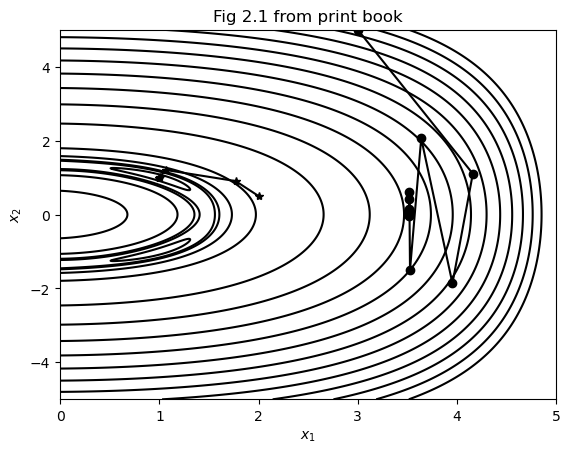

The line search failed at iteration 15
Termination with failure
Current values: maxit  =  20, armmax = 10
Give the history array a look to see what's happening.
  


In [44]:
TwoDexample();

### Section 2.7.2: Chandrasekhar H-Equation

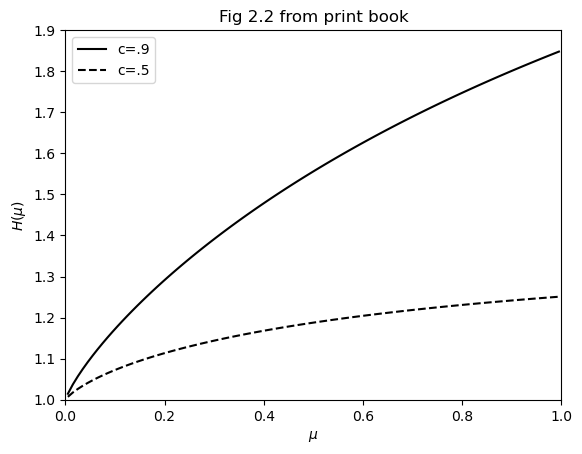

In [45]:
HeqSolutions();

### Section 2.7.3: A Two-Point Boundary Value Problem

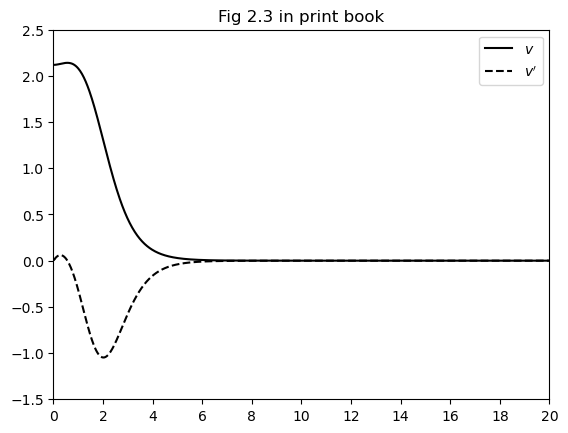

In [46]:
BVPsolution(801, Float64);

### Section 2.7.4: Stiff Initial Value Problems and the Buckling Beam

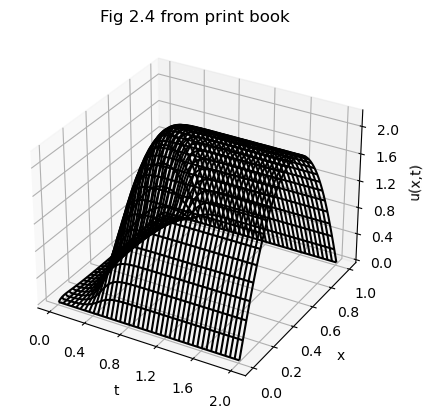

In [47]:
beamtimedep();

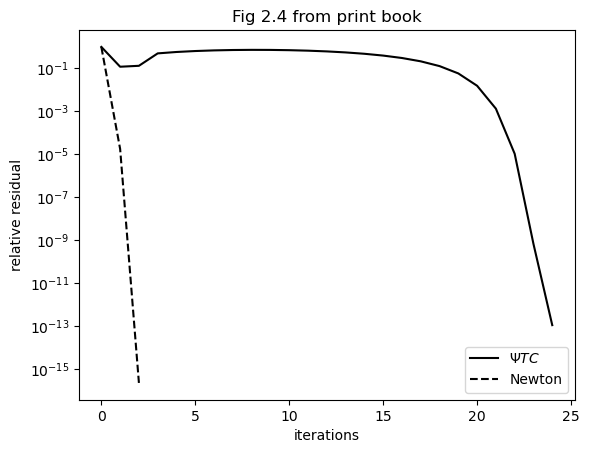

In [48]:
beamptc();

## Next notebook = [Section 2.8: Solvers for Chapter 2](SIAMFANLCh2s.ipynb)